In [26]:
import numpy as np
from numpy import pi
import src.disclination as disc
import matplotlib.pyplot as plt
from importlib import reload
reload(disc)

<module 'src.disclination' from '/home/mark/Dropbox/VS_Code_Projects/tci_disclinations/src/disclination.py'>

In [91]:
# Parameters
nx = 4
norb = 8
n_tot = norb * nx ** 3

mass = 2
phs_mass = 2
hoti_mass = 0

flux = 0.13 * pi


In [92]:
# Generate C4 symmetric basis
rot_op = disc.rotation_matrix(nx)

quadrant_states_basis = np.zeros((n_tot, n_tot // 4), dtype=complex)
c4_basis = np.zeros((n_tot, n_tot), dtype=complex)

for xx in range( nx // 2):
    for yy in range( nx // 2):
        for zz in range(nx):
            for ii in range(norb):
                site_ind = ii + xx * norb + yy * nx * norb + zz * nx ** 2 * norb
                basis_ind = ii + xx * norb + yy * nx // 2 * norb + zz * nx * nx // 4 * norb
                quadrant_states_basis[site_ind, basis_ind] = 1

for rr in range(4):
    temp = quadrant_states_basis
    for mm in range(4):
        if mm != 0:
            temp = np.exp(1j * rr * pi / 2) * rot_op @ temp
        c4_basis[:, rr * n_tot // 4:(rr + 1) * n_tot // 4] += temp / 2

In [93]:
# Build Hamiltonian, add flux in a C4 symmetric manner
h = disc.defect_free_hamiltonian(nx, mass, phs_mass, hoti_mass)
h = np.reshape(h, (nx, nx, nx, norb, nx, nx, nx, norb))

phi = 1j * flux / (2 * pi)

for zz in range(nx):
    for ii in range(nx // 2):
        h[zz, ii, nx // 2,     :, zz, ii, nx // 2 - 1, :] *= np.exp(phi / 4)
        h[zz, ii, nx // 2 - 1, :, zz, ii, nx // 2,     :] *= np.exp(-phi / 4)

        h[zz, ii + nx // 2, nx // 2,     :, zz, ii + nx // 2, nx // 2 - 1, :] *= np.exp(-phi / 4)
        h[zz, ii + nx // 2, nx // 2 - 1, :, zz, ii + nx // 2, nx // 2,     :] *= np.exp(phi / 4)
        
        h[zz, nx // 2,     ii, :, zz, nx // 2 - 1, ii, :] *= np.exp(-phi / 4)
        h[zz, nx // 2 - 1, ii, :, zz, nx // 2,     ii, :] *= np.exp(phi / 4)

        h[zz, nx // 2,     ii + nx // 2, :, zz, nx // 2 - 1, ii + nx // 2, :] *= np.exp(phi / 4)
        h[zz, nx // 2 - 1, ii + nx // 2, :, zz, nx // 2,     ii + nx // 2, :] *= np.exp(-phi / 4)

h = np.reshape(h, (norb * nx * nx * nx, norb * nx * nx * nx))

In [94]:
# Check for symmetry
commutator = rot_op @ h - h @ rot_op
print(f'Commutator maximum value: {np.max(np.abs(commutator))}')

Commutator maximum value: 3.122502256758253e-17


Unitarity check (small is good): 1.4409059796375077e-16


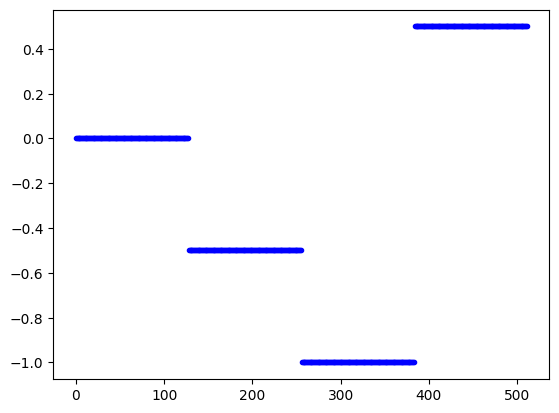

In [95]:
# plt.imshow(np.abs(c4_basis.conj().T @ c4_basis)[:n_tot // nx, :n_tot // nx])
print(f'Unitarity check (small is good): {np.max(np.abs(np.identity(n_tot) - c4_basis.conj().T @ c4_basis))}')

plt.plot(np.angle(np.diag(c4_basis.conj().T @ rot_op @ c4_basis) * np.exp(1j * 1e-14))/ (pi), 'b.')
plt.show()

In [106]:
# Rotate Hamiltonian into a C4 eigenvalue basis, separate out blocks
h_rot = c4_basis.conj().T @ h @ c4_basis
n = h_rot.shape[0]
h_c4_sectors = [h_rot[ii * n // 4: (ii + 1) * n // 4, ii * n // 4: (ii + 1) * n // 4] for ii in range(4)]

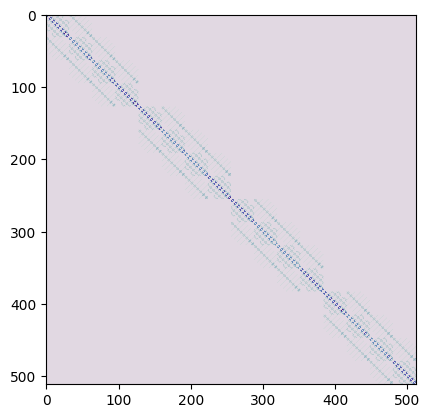

In [107]:
plt.imshow(np.abs(h_rot), cmap='twilight')
plt.show()

In [108]:
# Calculate density in each sector
u_c4_sectors = []
v_c4_sectors = []

for mat in h_c4_sectors:
    temp_u, temp_v = np.linalg.eigh(mat)
    u_c4_sectors.append(temp_u)
    v_c4_sectors.append(temp_v)

def calculate_rho(evals, evecs):
    rho = np.zeros((nx, nx * nx // 4))

    for ii, energy in enumerate(evals):
        if energy <= 0:
            wf = evecs[:, ii]
            prob_density = np.multiply(np.conj(wf), wf)
            temp_rho = np.reshape(prob_density, (nx, nx * nx // 4, norb))
            rho += np.sum(temp_rho, axis=-1).real

    return rho - norb // 2

rho_c4_sectors = [calculate_rho(u_c4_sectors[ii], v_c4_sectors[ii]) for ii in range(4)]

In [109]:
# Sum charge density over top half of the crystal, calculate bound angular momentum
rho_summed_c4_sectors = [np.sum(rho_c4_sectors[ii][nx//2:]) for ii in range(4)]
print(rho_summed_c4_sectors)
surf_angular_momentum = np.sum([np.exp(1j * rr * pi / 2) * rho_summed_c4_sectors[rr] for rr in range(4)])

[8.881784197001252e-16, 6.217248937900877e-15, 1.0658141036401503e-14, -3.552713678800501e-15]


In [110]:
surf_angular_momentum

(-9.769962616701378e-15+9.769962616701379e-15j)